In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from dotenv import load_dotenv
import os

load_dotenv()
project_root = Path(os.getenv("root"))
raw_data_dir = project_root / "data" / "raw" / "cmi-detect-behavior-with-sensor-data"

pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv(raw_data_dir / "train.csv")
train_demographics = pd.read_csv(raw_data_dir / "train_demographics.csv")
test = pd.read_csv(raw_data_dir / "test.csv")
test_demographics = pd.read_csv(raw_data_dir / "test_demographics.csv")

print(train.shape, train_demographics.shape, test.shape, test_demographics.shape)

(574945, 341) (81, 8) (107, 336) (2, 8)


In [6]:
acc_cols = [col for col in train.columns if "acc" in col]
rot_cols = [col for col in train.columns if "rot" in col]
thm_cols = [col for col in train.columns if "thm" in col]
tof1_cols = [col for col in train.columns if col.startswith("tof_1")]
tof2_cols = [col for col in train.columns if col.startswith("tof_2")]
tof3_cols = [col for col in train.columns if col.startswith("tof_3")]
tof4_cols = [col for col in train.columns if col.startswith("tof_4")]
tof5_cols = [col for col in train.columns if col.startswith("tof_5")]
tof_cols = tof1_cols + tof2_cols + tof3_cols + tof4_cols + tof5_cols
itof1_cols = [f"i{col}" for col in tof1_cols]
itof2_cols = [f"i{col}" for col in tof2_cols]
itof3_cols = [f"i{col}" for col in tof3_cols]
itof4_cols = [f"i{col}" for col in tof4_cols]
itof5_cols = [f"i{col}" for col in tof5_cols]
itof_cols = itof1_cols + itof2_cols + itof3_cols + itof4_cols + itof5_cols

len(acc_cols), len(rot_cols), len(thm_cols), len(tof1_cols), len(tof2_cols), len(tof3_cols), len(tof4_cols), len(tof5_cols), len(itof1_cols), len(itof2_cols), len(itof3_cols), len(itof4_cols), len(itof5_cols)


(3, 4, 5, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64)

In [7]:
tof_cols = tof1_cols + tof2_cols + tof3_cols + tof4_cols + tof5_cols
itof_cols = [f"i{col}" for col in tof_cols]

train.loc[:, itof_cols] = ((train[tof_cols]!=-1) & (train[tof_cols].notna())).astype(float).values
test.loc[:, itof_cols] = ((test[tof_cols]!=-1) & (test[tof_cols].notna())).astype(float).values

# train.head()

In [8]:
train[['sequence_id'] + acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].head()

,sequence_id,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,itof_1_v0,itof_1_v1,itof_1_v2,itof_1_v3,itof_1_v4,itof_1_v5,itof_1_v6,itof_1_v7,itof_1_v8,itof_1_v9,itof_1_v10,itof_1_v11,itof_1_v12,itof_1_v13,itof_1_v14,itof_1_v15,itof_1_v16,itof_1_v17,itof_1_v18,itof_1_v19,itof_1_v20,itof_1_v21,itof_1_v22,itof_1_v23,itof_1_v24,itof_1_v25,itof_1_v26,itof_1_v27,itof_1_v28,itof_1_v29,itof_1_v30,itof_1_v31,itof_1_v32,itof_1_v33,itof_1_v34,itof_1_v35,itof_1_v36,itof_1_v37,itof_1_v38,itof_1_v39,itof_1_v40,itof_1_v41,itof_1_v42,itof_1_v43,itof_1_v44,itof_1_v45,itof_1_v46,itof_1_v47,itof_1_v48,itof_1_v49,itof_1_v50,itof_1_v51,itof_1_v52,itof_1_v53,itof_1_v54,itof_1_v55,itof_1_v56,itof_1_v57,itof_1_v58,itof_1_v59,itof_1_v60,itof_1_v61,itof_1_v62,itof_1_v63,itof_2_v0,itof_2_v1,itof_2_v2,itof_2_v3,itof_2_v4,itof_2_v5,itof_2_v6,i

In [9]:
test[['sequence_id'] + acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].head()

,sequence_id,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,itof_1_v0,itof_1_v1,itof_1_v2,itof_1_v3,itof_1_v4,itof_1_v5,itof_1_v6,itof_1_v7,itof_1_v8,itof_1_v9,itof_1_v10,itof_1_v11,itof_1_v12,itof_1_v13,itof_1_v14,itof_1_v15,itof_1_v16,itof_1_v17,itof_1_v18,itof_1_v19,itof_1_v20,itof_1_v21,itof_1_v22,itof_1_v23,itof_1_v24,itof_1_v25,itof_1_v26,itof_1_v27,itof_1_v28,itof_1_v29,itof_1_v30,itof_1_v31,itof_1_v32,itof_1_v33,itof_1_v34,itof_1_v35,itof_1_v36,itof_1_v37,itof_1_v38,itof_1_v39,itof_1_v40,itof_1_v41,itof_1_v42,itof_1_v43,itof_1_v44,itof_1_v45,itof_1_v46,itof_1_v47,itof_1_v48,itof_1_v49,itof_1_v50,itof_1_v51,itof_1_v52,itof_1_v53,itof_1_v54,itof_1_v55,itof_1_v56,itof_1_v57,itof_1_v58,itof_1_v59,itof_1_v60,itof_1_v61,itof_1_v62,itof_1_v63,itof_2_v0,itof_2_v1,itof_2_v2,itof_2_v3,itof_2_v4,itof_2_v5,itof_2_v6,i

In [10]:
class MaskedStandardScaler:
    def __init__(self, eps: float = 1e-8, mask_fill_value: float = 0):
        self.eps = eps
        self.means = None
        self.stds = None
        self.X_cols = None
        self.mask_cols = None
        self.mask_fill_value = mask_fill_value

    def create_mask(self, df: pd.DataFrame):
        mask = pd.DataFrame(index=df.index, columns=self.X_cols)
        if self.mask_cols is None:
            mask.loc[:, :] = True
            return mask
        
        for X_col, mask_col in zip(self.X_cols, self.mask_cols):
            if mask_col is None:
                mask[X_col] = df[X_col].notna()
            else:
                mask[X_col] = df[mask_col].astype(bool)
        return mask

    def fit(self, df: pd.DataFrame, X_cols: list[str], mask_cols: list[str] = None):
        self.X_cols = X_cols
        self.mask_cols = mask_cols

        X = df[X_cols].to_numpy(dtype=np.float32)
        mask = self.create_mask(df).to_numpy(dtype=bool)

        self.means = np.nanmean(np.where(mask, X, np.nan), axis=0)
        self.stds = np.nanstd(np.where(mask, X, np.nan), axis=0) + self.eps

    def transform(self, df: pd.DataFrame, inplace: bool = True):
        if not inplace:
            df = df.copy()

        X = df[self.X_cols].to_numpy(dtype=np.float32)
        mask = self.create_mask(df).to_numpy(dtype=bool)

        X_std = (X - self.means) / self.stds
        X_std[~mask] = self.mask_fill_value

        df[self.X_cols] = X_std
        return df
    
    def fit_transform(self, df: pd.DataFrame, X_cols: list[str], mask_cols: list[str] = None, inplace: bool = True):
        self.fit(df, X_cols, mask_cols)
        return self.transform(df, inplace=inplace)


unmasked_cols = acc_cols + rot_cols + thm_cols
masked_cols = tof1_cols + tof2_cols + tof3_cols + tof4_cols + tof5_cols
X_cols = unmasked_cols + masked_cols
mask_cols = [None] * len(unmasked_cols) + [f"i{col}" for col in masked_cols]

scaler = MaskedStandardScaler()
scaler.fit_transform(train, X_cols, mask_cols, inplace=True)
scaler.transform(test, inplace=True)

# train.head()

,row_id,sequence_id,sequence_counter,subject,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,itof_1_v0,itof_1_v1,itof_1_v2,itof_1_v3,itof_1_v4,itof_1_v5,itof_1_v6,itof_1_v7,itof_1_v8,itof_1_v9,itof_1_v10,itof_1_v11,itof_1_v12,itof_1_v13,itof_1_v14,itof_1_v15,itof_1_v16,itof_1_v17,itof_1_v18,itof_1_v19,itof_1_v20,itof_1_v21,itof_1_v22,itof_1_v23,itof_1_v24,itof_1_v25,itof_1_v26,itof_1_v27,itof_1_v28,itof_1_v29,itof_1_v30,itof_1_v31,itof_1_v32,itof_1_v33,itof_1_v34,itof_1_v35,itof_1_v36,itof_1_v37,itof_1_v38,itof_1_v39,itof_1_v40,itof_1_v41,itof_1_v42,itof_1_v43,itof_1_v44,itof_1_v45,itof_1_v46,itof_1_v47,itof_1_v48,itof_1_v49,itof_1_v50,itof_1_v51,itof_1_v52,itof_1_v53,itof_1_v54,itof_1_v55,itof_1_v56,itof_1_v57,itof_1_v58,itof_1_v59,itof_1_v60,itof_1_v61,itof_1_v62,itof_1_v63,itof_2_v0,itof_2_v1,itof_2_v2,itof_2_v3

In [11]:
train[['sequence_id'] + acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].head()

,sequence_id,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,itof_1_v0,itof_1_v1,itof_1_v2,itof_1_v3,itof_1_v4,itof_1_v5,itof_1_v6,itof_1_v7,itof_1_v8,itof_1_v9,itof_1_v10,itof_1_v11,itof_1_v12,itof_1_v13,itof_1_v14,itof_1_v15,itof_1_v16,itof_1_v17,itof_1_v18,itof_1_v19,itof_1_v20,itof_1_v21,itof_1_v22,itof_1_v23,itof_1_v24,itof_1_v25,itof_1_v26,itof_1_v27,itof_1_v28,itof_1_v29,itof_1_v30,itof_1_v31,itof_1_v32,itof_1_v33,itof_1_v34,itof_1_v35,itof_1_v36,itof_1_v37,itof_1_v38,itof_1_v39,itof_1_v40,itof_1_v41,itof_1_v42,itof_1_v43,itof_1_v44,itof_1_v45,itof_1_v46,itof_1_v47,itof_1_v48,itof_1_v49,itof_1_v50,itof_1_v51,itof_1_v52,itof_1_v53,itof_1_v54,itof_1_v55,itof_1_v56,itof_1_v57,itof_1_v58,itof_1_v59,itof_1_v60,itof_1_v61,itof_1_v62,itof_1_v63,itof_2_v0,itof_2_v1,itof_2_v2,itof_2_v3,itof_2_v4,itof_2_v5,itof_2_v6,i

In [12]:
test[['sequence_id'] + acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].head()

,sequence_id,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,itof_1_v0,itof_1_v1,itof_1_v2,itof_1_v3,itof_1_v4,itof_1_v5,itof_1_v6,itof_1_v7,itof_1_v8,itof_1_v9,itof_1_v10,itof_1_v11,itof_1_v12,itof_1_v13,itof_1_v14,itof_1_v15,itof_1_v16,itof_1_v17,itof_1_v18,itof_1_v19,itof_1_v20,itof_1_v21,itof_1_v22,itof_1_v23,itof_1_v24,itof_1_v25,itof_1_v26,itof_1_v27,itof_1_v28,itof_1_v29,itof_1_v30,itof_1_v31,itof_1_v32,itof_1_v33,itof_1_v34,itof_1_v35,itof_1_v36,itof_1_v37,itof_1_v38,itof_1_v39,itof_1_v40,itof_1_v41,itof_1_v42,itof_1_v43,itof_1_v44,itof_1_v45,itof_1_v46,itof_1_v47,itof_1_v48,itof_1_v49,itof_1_v50,itof_1_v51,itof_1_v52,itof_1_v53,itof_1_v54,itof_1_v55,itof_1_v56,itof_1_v57,itof_1_v58,itof_1_v59,itof_1_v60,itof_1_v61,itof_1_v62,itof_1_v63,itof_2_v0,itof_2_v1,itof_2_v2,itof_2_v3,itof_2_v4,itof_2_v5,itof_2_v6,i

In [13]:
train_mis_cnt = train[acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].isna().sum()
train_mis_cnt[train_mis_cnt>0]

Series([], dtype: int64)

In [14]:
test_mis_cnt = test[acc_cols + rot_cols + thm_cols + tof_cols + itof_cols].isna().sum()
test_mis_cnt[test_mis_cnt>0]

Series([], dtype: int64)

In [15]:
train.groupby("sequence_id")["sequence_id"].count().describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])


count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
1%         43.000000
5%         46.000000
10%        48.000000
25%        51.000000
50%        59.000000
75%        78.000000
90%       103.000000
95%       127.000000
99%       210.000000
max       700.000000
Name: sequence_id, dtype: float64

In [16]:
label_freq = train[['sequence_id', 'gesture']].drop_duplicates(subset='sequence_id')['gesture'].value_counts(normalize=True)
label_freq

gesture
Forehead - pull hairline                      0.078518
Neck - pinch skin                             0.078518
Text on phone                                 0.078518
Neck - scratch                                0.078518
Forehead - scratch                            0.078518
Eyelash - pull hair                           0.078518
Above ear - pull hair                         0.078273
Eyebrow - pull hair                           0.078273
Cheek - pinch skin                            0.078150
Wave hello                                    0.058643
Write name in air                             0.058520
Pull air toward your face                     0.058520
Feel around in tray and pull out an object    0.019752
Write name on leg                             0.019752
Pinch knee/leg skin                           0.019752
Scratch knee/leg skin                         0.019752
Drink from bottle/cup                         0.019752
Glasses on/off                                0.019752
Na

In [17]:
import math
from scipy.stats import entropy

entropy(label_freq.values, base=2) / math.log(len(label_freq), 2)

np.float64(0.9550191082518557)

In [18]:
label_map = {label: idx for idx, label in enumerate(label_freq.index)}
label_map

{'Forehead - pull hairline': 0,
 'Neck - pinch skin': 1,
 'Text on phone': 2,
 'Neck - scratch': 3,
 'Forehead - scratch': 4,
 'Eyelash - pull hair': 5,
 'Above ear - pull hair': 6,
 'Eyebrow - pull hair': 7,
 'Cheek - pinch skin': 8,
 'Wave hello': 9,
 'Write name in air': 10,
 'Pull air toward your face': 11,
 'Feel around in tray and pull out an object': 12,
 'Write name on leg': 13,
 'Pinch knee/leg skin': 14,
 'Scratch knee/leg skin': 15,
 'Drink from bottle/cup': 16,
 'Glasses on/off': 17}

In [106]:
good = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]
bad = [0, 1, 3, 4, 5, 6, 7, 8]

In [19]:
train['gesture_id'] = train['gesture'].map(label_map)

cols = ['sequence_id', 'sequence_counter'] + acc_cols + rot_cols + thm_cols
feature_imu = acc_cols + rot_cols
feature_1d = acc_cols + rot_cols + thm_cols
feature_2d_tof = tof1_cols + tof2_cols + tof3_cols + tof4_cols + tof5_cols
feature_2d_itof = itof1_cols + itof2_cols + itof3_cols + itof4_cols + itof5_cols

id_sequence = []
feature_imu_sequence = []
feature_1d_sequence = []
feature_2d_tof_sequence = []
feature_2d_itof_sequence = []
labels = []

for seq_id, seq_df in train.groupby("sequence_id"):
    id_sequence.append(seq_id)
    
    feature_imu_sequence.append(torch.tensor(seq_df[feature_imu].values))
    feature_1d_sequence.append(torch.tensor(seq_df[feature_1d].values))

    flat_tensor_tof = torch.tensor(seq_df[feature_2d_tof].values)
    feature_2d_tof_sequence.append(flat_tensor_tof.reshape(-1, 5, 8, 8))

    flat_tensor_itof = torch.tensor(seq_df[feature_2d_itof].values)
    feature_2d_itof_sequence.append(flat_tensor_itof.reshape(-1, 5, 8, 8))

    labels.append(seq_df['gesture_id'].iloc[-1].item())

/tmp/ipykernel_1481/2290875634.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['gesture_id'] = train['gesture'].map(label_map)


In [20]:
len(id_sequence), len(feature_imu_sequence), len(feature_1d_sequence), len(feature_2d_tof_sequence), len(feature_2d_itof_sequence), len(labels)

(8151, 8151, 8151, 8151, 8151, 8151)

In [21]:
train[feature_1d + feature_2d_tof].isna().mean().max()

np.float64(0.0)

In [22]:
[t.shape for t in feature_imu_sequence]

[torch.Size([57, 7]),
 torch.Size([68, 7]),
 torch.Size([53, 7]),
 torch.Size([61, 7]),
 torch.Size([54, 7]),
 torch.Size([159, 7]),
 torch.Size([56, 7]),
 torch.Size([40, 7]),
 torch.Size([78, 7]),
 torch.Size([50, 7]),
 torch.Size([54, 7]),
 torch.Size([88, 7]),
 torch.Size([67, 7]),
 torch.Size([61, 7]),
 torch.Size([54, 7]),
 torch.Size([55, 7]),
 torch.Size([81, 7]),
 torch.Size([87, 7]),
 torch.Size([73, 7]),
 torch.Size([80, 7]),
 torch.Size([46, 7]),
 torch.Size([81, 7]),
 torch.Size([234, 7]),
 torch.Size([45, 7]),
 torch.Size([161, 7]),
 torch.Size([73, 7]),
 torch.Size([61, 7]),
 torch.Size([86, 7]),
 torch.Size([50, 7]),
 torch.Size([77, 7]),
 torch.Size([53, 7]),
 torch.Size([77, 7]),
 torch.Size([54, 7]),
 torch.Size([55, 7]),
 torch.Size([55, 7]),
 torch.Size([45, 7]),
 torch.Size([50, 7]),
 torch.Size([65, 7]),
 torch.Size([57, 7]),
 torch.Size([169, 7]),
 torch.Size([83, 7]),
 torch.Size([61, 7]),
 torch.Size([108, 7]),
 torch.Size([107, 7]),
 torch.Size([53, 7]),
 tor

In [23]:
# [t.shape for t in feature_imu_sequence]
# [t.shape for t in feature_1d_sequence]
# [t.shape for t in feature_2d_tof_sequence]
[t.shape for t in feature_2d_itof_sequence]

[torch.Size([57, 5, 8, 8]),
 torch.Size([68, 5, 8, 8]),
 torch.Size([53, 5, 8, 8]),
 torch.Size([61, 5, 8, 8]),
 torch.Size([54, 5, 8, 8]),
 torch.Size([159, 5, 8, 8]),
 torch.Size([56, 5, 8, 8]),
 torch.Size([40, 5, 8, 8]),
 torch.Size([78, 5, 8, 8]),
 torch.Size([50, 5, 8, 8]),
 torch.Size([54, 5, 8, 8]),
 torch.Size([88, 5, 8, 8]),
 torch.Size([67, 5, 8, 8]),
 torch.Size([61, 5, 8, 8]),
 torch.Size([54, 5, 8, 8]),
 torch.Size([55, 5, 8, 8]),
 torch.Size([81, 5, 8, 8]),
 torch.Size([87, 5, 8, 8]),
 torch.Size([73, 5, 8, 8]),
 torch.Size([80, 5, 8, 8]),
 torch.Size([46, 5, 8, 8]),
 torch.Size([81, 5, 8, 8]),
 torch.Size([234, 5, 8, 8]),
 torch.Size([45, 5, 8, 8]),
 torch.Size([161, 5, 8, 8]),
 torch.Size([73, 5, 8, 8]),
 torch.Size([61, 5, 8, 8]),
 torch.Size([86, 5, 8, 8]),
 torch.Size([50, 5, 8, 8]),
 torch.Size([77, 5, 8, 8]),
 torch.Size([53, 5, 8, 8]),
 torch.Size([77, 5, 8, 8]),
 torch.Size([54, 5, 8, 8]),
 torch.Size([55, 5, 8, 8]),
 torch.Size([55, 5, 8, 8]),
 torch.Size([45, 

In [24]:
feature_1d_sequence[0][0]

tensor([ 0.8724,  0.8841,  0.6258, -1.0010, -0.5053, -0.7134, -1.2327,  0.5778,
         1.5940,  0.6914,  0.4587,  0.6729])

In [25]:
feature_2d_tof_sequence[0][0][0]

tensor([[ 0.2853,  0.2955,  0.2338,  0.2648, -0.3106, -0.6499, -0.8103, -0.8660],
        [ 0.0000,  0.0000,  0.5184,  0.5143,  0.3349, -0.4625, -0.7346, -0.8147],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.7470, -0.0255, -0.4971, -0.6850],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4243, -0.1191, -0.4580],
        [ 0.2055,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3291, -0.0837],
        [ 0.1516,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3221],
        [ 0.1868,  0.4693,  0.6387,  0.0000,  0.3662,  0.4352,  0.0000,  0.0000],
        [ 0.0000,  0.2366,  0.4924,  0.7666,  0.2848,  0.4014,  0.0000,  0.3347]])

In [26]:
feature_2d_itof_sequence[0][0][0]

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 1.]], dtype=torch.float64)

In [34]:
# labels

In [27]:
train_demographics.head()

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


In [28]:
train_demographics.isna().sum()

subject                 0
adult_child             0
age                     0
sex                     0
handedness              0
height_cm               0
shoulder_to_wrist_cm    0
elbow_to_wrist_cm       0
dtype: int64

In [29]:
test_demographics.isna().sum()

subject                 0
adult_child             0
age                     0
sex                     0
handedness              0
height_cm               0
shoulder_to_wrist_cm    0
elbow_to_wrist_cm       0
dtype: int64

In [30]:
train_seq_demographics = pd.merge(train[['sequence_id', 'subject']].drop_duplicates(), train_demographics, on='subject', how='left')
demo_features = ['adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']
demo_scaler = MaskedStandardScaler()
demo_scaler.fit_transform(train_seq_demographics, demo_features, inplace=True)

train_seq_demographics.head()

,sequence_id,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007,SUBJ_059520,-1.050985,-0.966665,0.794673,0.378203,-0.464494,0.093278,-0.482164
1,SEQ_000008,SUBJ_020948,0.951488,0.204918,0.794673,0.378203,0.480256,-0.522022,0.180979
2,SEQ_000013,SUBJ_040282,-1.050985,-0.966665,0.794673,0.378203,-1.031344,-1.547521,0.180979
3,SEQ_000016,SUBJ_052342,-1.050985,-0.869033,-1.258379,0.378203,0.291306,0.503478,0.180979
4,SEQ_000018,SUBJ_032165,-1.050985,-0.869033,-1.258379,0.378203,-0.275544,0.093278,-0.813736


In [31]:
feature_demo = torch.tensor(train_seq_demographics[demo_features].values)
feature_demo.shape

torch.Size([8151, 7])

In [32]:
labels = torch.tensor(labels)
labels.shape

torch.Size([8151])

In [47]:
# labels, feature_demo, feature_imu_sequence, feature_1d_sequence, feature_2d_tof_sequence, feature_2d_itof_sequence

Next step: 
1. build torch dataset and data loader  
2. design model structure  
    a. imu only  
        i. LSTM  
        ii. FFT  
    b. all features  
        i. CNN + LSTM  
        ii. FFT + CNN + LSTM  

In [33]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


class CMI_Dataset(Dataset):
    def __init__(self, labels, demo, feature_imu_sequence, feature_1d_sequence, feature_2d_tof_sequence, feature_2d_itof_sequence):
        self.labels = labels
        self.demo = demo
        self.feature_imu_seq = feature_imu_sequence
        self.feature_1d_seq = feature_1d_sequence
        self.feature_2d_tof_seq = feature_2d_tof_sequence
        self.feature_2d_itof_seq = feature_2d_itof_sequence

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'label': self.labels[idx],
            'demo': self.demo[idx],
            'seq_imu': self.feature_imu_seq[idx],
            'seq_1d': self.feature_1d_seq[idx],
            'seq_2d_tof': self.feature_2d_tof_seq[idx],
            'seq_2d_itof': self.feature_2d_itof_seq[idx],
        }


def collate_fn(batch):
    labels = torch.tensor([item['label'] for item in batch])
    demo = torch.stack([item['demo'] for item in batch])

    seq_imu_list = [item['seq_imu'] for item in batch]  # [B, T, 7]
    seq_1d_list = [item['seq_1d'] for item in batch]    # [B, T, 12]
    seq_2d_tof_list = [item['seq_2d_tof'] for item in batch]    # [B, T, 5, 8, 8]
    seq_2d_itof_list = [item['seq_2d_itof'] for item in batch]  # [B, T, 5, 8, 8]

    lengths = torch.tensor([t.size(0) for t in seq_imu_list])
    max_len = lengths.max()
    mask = torch.arange(max_len)[None, :] < lengths[:, None]

    # Pad 1D
    seq_imu = pad_sequence(seq_imu_list, batch_first=True)    # [B, T, D]
    seq_1d = pad_sequence(seq_1d_list, batch_first=True)      # [B, T, D]

    # Pad 2D
    seq_2d_tof = pad_sequence(seq_2d_tof_list, batch_first=True)    # [B, T, 5, 8, 8]
    seq_2d_itof = pad_sequence(seq_2d_itof_list, batch_first=True)  # [B, T, 5, 8, 8]

    return {
        'labels': labels,
        'demo': demo,
        'seq_imu': seq_imu,
        'seq_1d': seq_1d,
        'seq_2d_tof': seq_2d_tof,
        'seq_2d_itof': seq_2d_itof,
        'mask': mask,
        'lengths': lengths,
    }

In [82]:
import torch
import torch.nn as nn


class IMU_LSTM_Model(nn.Module):
    def __init__(self, num_classes=18, input_dim_demo=7, input_dim_imu=7, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim_imu, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + input_dim_demo, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, demo, imu, mask=None):
        # imu: [B, T, D]
        lstm_out, _ = self.lstm(imu)  # [B, T, 2H]

        if mask is not None:
            mask = mask.unsqueeze(-1)  # [B, T, 1]
            lstm_out = lstm_out * mask  # zero out padding
            summed = lstm_out.sum(dim=1)
            lengths = mask.sum(dim=1).clamp(min=1e-6)
            pooled = summed / lengths  # mean over valid steps
        else:
            pooled = lstm_out.mean(dim=1)  # [B, 2H]

        x = torch.cat([pooled, demo], dim=1)  # [B, 2H + demo]
        return self.mlp(self.dropout(x))
        

In [83]:
imu_model = IMU_LSTM_Model(num_classes=18, input_dim_demo=7, input_dim_imu=7, hidden_dim=32, num_layers=1)
sum(p.numel() for p in imu_model.parameters() if p.requires_grad)

16274

In [90]:
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedKFold

dataset = CMI_Dataset(
    labels, 
    feature_demo, 
    feature_imu_sequence, 
    feature_1d_sequence, 
    feature_2d_tof_sequence, 
    feature_2d_itof_sequence
)
imu_model = IMU_LSTM_Model(num_classes=18, input_dim_demo=7, input_dim_imu=7, hidden_dim=64, num_layers=1)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(feature_demo, labels)):
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    for batch in train_loader:
        print(batch['labels'].shape)
        print(batch['demo'].shape)
        print(batch['mask'].shape)
        print(batch['seq_imu'].shape)
        print(batch['seq_1d'].shape)
        print(batch['seq_2d_tof'].shape)
        print(batch['seq_2d_itof'].shape)
        break

    break

torch.Size([32])
torch.Size([32, 7])
torch.Size([32, 210])
torch.Size([32, 210, 7])
torch.Size([32, 210, 12])
torch.Size([32, 210, 5, 8, 8])
torch.Size([32, 210, 5, 8, 8])


In [91]:
criterion = nn.CrossEntropyLoss()
logits = imu_model(batch['demo'], batch['seq_imu'], batch['mask'])
loss = criterion(logits, batch['labels'])


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np


def train_model_cv(
    dataset, labels, model_class, num_epochs=32, k_folds=4, batch_size=32, lr=1e-3,
    weight_decay=1e-4, eval_every=1, device="cuda" if torch.cuda.is_available() else "cpu"
):
    criterion = nn.CrossEntropyLoss()
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_history = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print("\n")

        train_loader = DataLoader(
            Subset(dataset, train_idx), batch_size=batch_size,
            shuffle=True, collate_fn=collate_fn
        )
        val_loader = DataLoader(
            Subset(dataset, val_idx), batch_size=batch_size,
            shuffle=False, collate_fn=collate_fn
        )

        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        early_stop_patience = 10
        best_val_loss = float('inf')
        epochs_no_improve = 0

        fold_result = {
            "model": [],
            "train_loss": [],
            "val_loss": [],
            "train_idx": train_idx,
            "val_idx": val_idx,
            "lr": [],
            "best_model": None
        }

        for epoch in range(1, num_epochs + 1):
            model.train()
            train_losses = []

            for batch in train_loader:
                labels = batch["labels"].to(device)
                demo = batch["demo"].to(device)
                seq_imu = batch["seq_imu"].to(device)
                mask = batch["mask"].to(device)

                assert not torch.isnan(seq_imu).any()
                assert not torch.isinf(seq_imu).any()

                assert not torch.isnan(demo).any()
                assert not torch.isinf(demo).any()

                assert not torch.isnan(mask).any()
                assert not torch.isinf(mask).any()

                logits = model(demo, seq_imu, mask)
                loss = criterion(logits, labels)
                # print(loss.item())

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_losses.append(loss.item())

            # Evaluation
            if epoch % eval_every == 0:
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for batch in val_loader:
                        labels = batch["labels"].to(device)
                        demo = batch["demo"].to(device)
                        seq_imu = batch["seq_imu"].to(device)
                        mask = batch["mask"].to(device)

                        logits = model(demo, seq_imu, mask)
                        loss = criterion(logits, labels)
                        val_losses.append(loss.item())

                avg_train_loss = np.mean(train_losses)
                avg_val_loss = np.mean(val_losses)
                cur_lr = optimizer.param_groups[0]['lr']
                scheduler.step(avg_val_loss)

                print(f"Fold {fold+1}/{k_folds} | Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

                # Early stopping logic
                if avg_val_loss < best_val_loss - 2e-2:
                    best_val_loss = avg_val_loss
                    best_model = model
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= early_stop_patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

                # Logging
                fold_result["model"].append(model)
                fold_result["train_loss"].append(avg_train_loss)
                fold_result["val_loss"].append(avg_val_loss)
                fold_result["lr"].append(cur_lr)
                fold_result["best_model"] = best_model

        fold_history.append(fold_result)

    return fold_history


def predict(model, dataset, pred_idx, batch_size=32, device="cuda" if torch.cuda.is_available() else "cpu"):
    pred_loader = DataLoader(
        Subset(dataset, pred_idx), batch_size=batch_size,
        shuffle=False, collate_fn=collate_fn
    )

    labels, preds = [], []
    
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in pred_loader:
            label = batch["labels"].to(device)
            demo = batch["demo"].to(device)
            seq_imu = batch["seq_imu"].to(device)
            mask = batch["mask"].to(device)

            logits = model(demo, seq_imu, mask)
            pred = logits.argmax(dim=1)
            labels.append(label)
            preds.append(pred)

    labels = torch.cat(labels, dim=0).to('cpu')
    preds = torch.cat(preds, dim=0).to('cpu')

    return labels, preds

In [85]:
dataset = CMI_Dataset(
    labels, 
    feature_demo, 
    feature_imu_sequence, 
    feature_1d_sequence, 
    feature_2d_tof_sequence, 
    feature_2d_itof_sequence
)

training_history = train_model_cv(dataset, labels, model_class=IMU_LSTM_Model, num_epochs=200, eval_every=1, lr=1e-3)



Fold 1/4 | Epoch 01 | Train Loss: 2.6422 | Val Loss: 2.4009
Fold 1/4 | Epoch 02 | Train Loss: 2.3455 | Val Loss: 2.2645
Fold 1/4 | Epoch 03 | Train Loss: 2.2312 | Val Loss: 2.1849
Fold 1/4 | Epoch 04 | Train Loss: 2.1680 | Val Loss: 2.1102
Fold 1/4 | Epoch 05 | Train Loss: 2.1066 | Val Loss: 2.0654
Fold 1/4 | Epoch 06 | Train Loss: 2.0659 | Val Loss: 2.0391
Fold 1/4 | Epoch 07 | Train Loss: 2.0291 | Val Loss: 2.0064
Fold 1/4 | Epoch 08 | Train Loss: 1.9908 | Val Loss: 1.9749
Fold 1/4 | Epoch 09 | Train Loss: 1.9644 | Val Loss: 1.9483
Fold 1/4 | Epoch 10 | Train Loss: 1.9417 | Val Loss: 1.9368
Fold 1/4 | Epoch 11 | Train Loss: 1.9195 | Val Loss: 1.8859
Fold 1/4 | Epoch 12 | Train Loss: 1.8833 | Val Loss: 1.8799
Fold 1/4 | Epoch 13 | Train Loss: 1.8702 | Val Loss: 1.8616
Fold 1/4 | Epoch 14 | Train Loss: 1.8560 | Val Loss: 1.8178
Fold 1/4 | Epoch 15 | Train Loss: 1.8353 | Val Loss: 1.8131
Fold 1/4 | Epoch 16 | Train Loss: 1.8132 | Val Loss: 1.8053
Fold 1/4 | Epoch 17 | Train Loss: 1.80

In [115]:
import pickle

with open("../results/imu_only_baseline_model.pkl", "wb") as f:
    pickle.dump(training_history, f)

: 

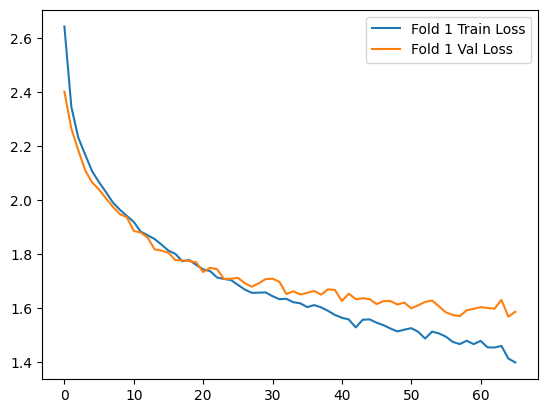

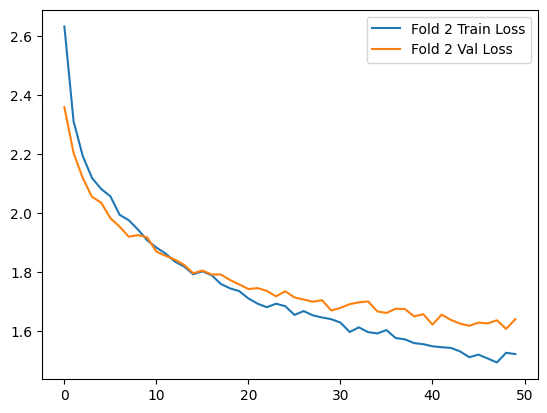

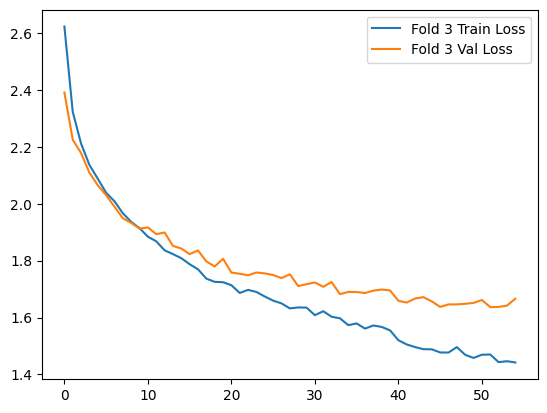

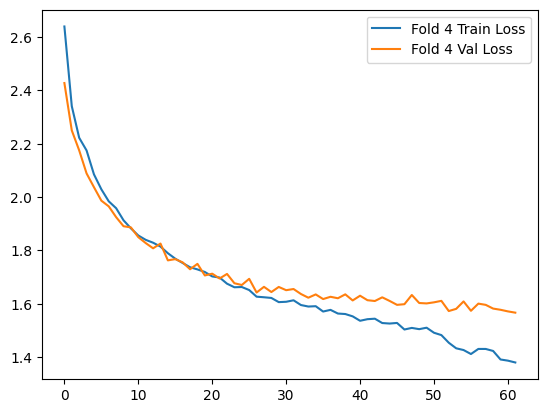

In [86]:


for i, fold in enumerate(training_history):
    # models = fold['models']
    train_loss = fold['train_loss']
    val_loss = fold['val_loss']

    plt.plot(train_loss, label=f'Fold {i+1} Train Loss')
    plt.plot(val_loss, label=f'Fold {i+1} Val Loss')
    plt.legend()
    plt.show()


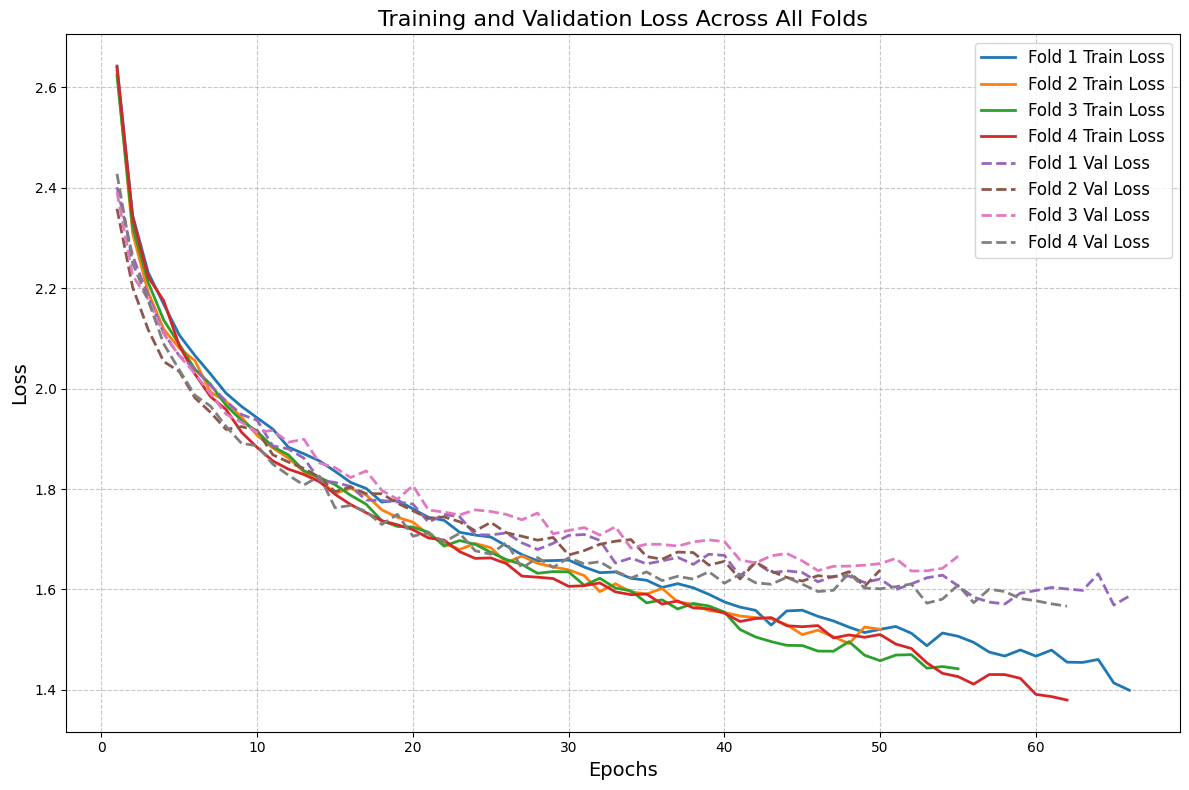

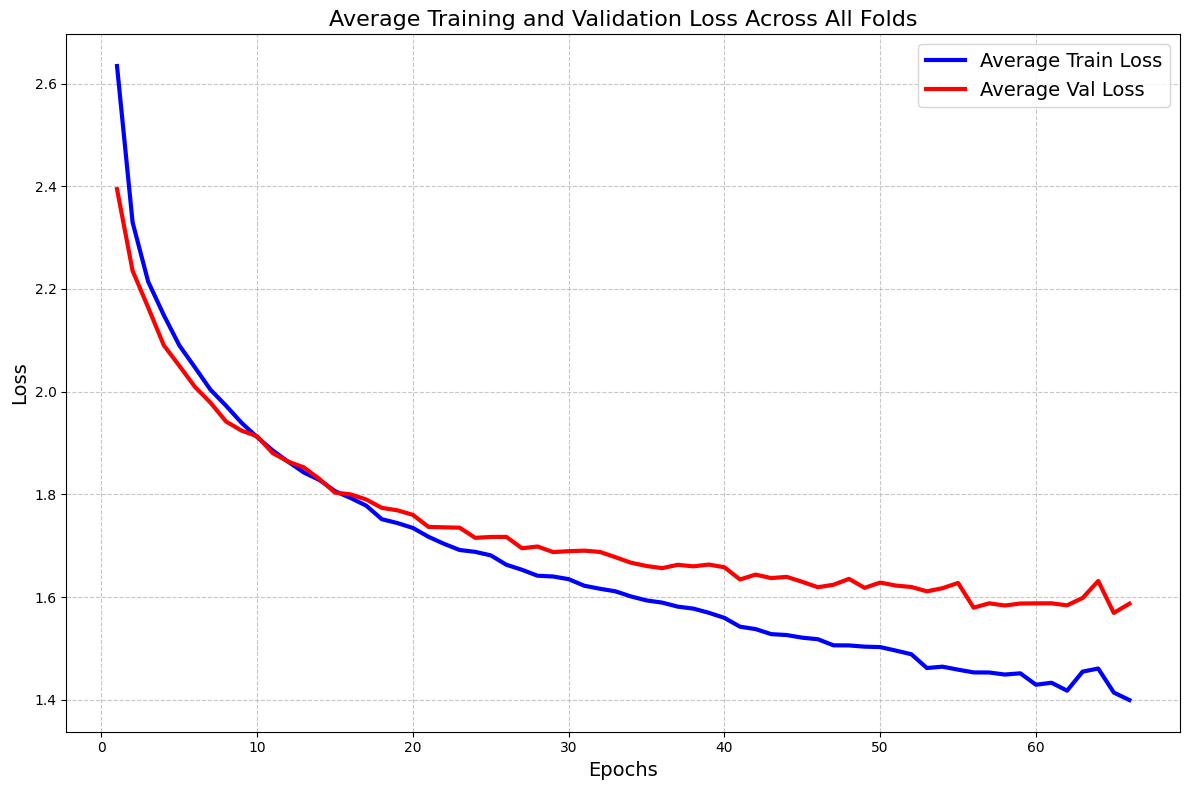

In [87]:
plt.figure(figsize=(12, 8))

# Plot training loss for all folds
for i, fold in enumerate(training_history):
    train_loss = fold['train_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, '-', linewidth=2, label=f'Fold {i+1} Train Loss')

# Plot validation loss for all folds
for i, fold in enumerate(training_history):
    val_loss = fold['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, '--', linewidth=2, label=f'Fold {i+1} Val Loss')

plt.title('Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display average loss across folds
max_epochs = max([len(fold['train_loss']) for fold in training_history])
avg_train_loss = np.zeros(max_epochs)
avg_val_loss = np.zeros(max_epochs)
counts_train = np.zeros(max_epochs)
counts_val = np.zeros(max_epochs)

for fold in training_history:
    for i, loss in enumerate(fold['train_loss']):
        avg_train_loss[i] += loss
        counts_train[i] += 1
    for i, loss in enumerate(fold['val_loss']):
        avg_val_loss[i] += loss
        counts_val[i] += 1

# Compute averages
for i in range(max_epochs):
    if counts_train[i] > 0:
        avg_train_loss[i] /= counts_train[i]
    if counts_val[i] > 0:
        avg_val_loss[i] /= counts_val[i]

# Plot average losses
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_epochs + 1), avg_train_loss, 'b-', linewidth=3, label='Average Train Loss')
plt.plot(range(1, max_epochs + 1), avg_val_loss, 'r-', linewidth=3, label='Average Val Loss')
plt.title('Average Training and Validation Loss Across All Folds', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [88]:
training_history[0].keys()

dict_keys(['model', 'train_loss', 'val_loss', 'train_idx', 'val_idx', 'lr', 'best_model'])

In [91]:
training_history[0]['val_idx']

array([   1,   15,   16, ..., 8142, 8146, 8149], shape=(2038,))

In [96]:
labels, preds = [], []
for fold in training_history:
    model = fold['best_model']
    pred_idx = fold['val_idx']
    fold_labels,  fold_preds = predict(model, dataset, pred_idx)
    labels.append(fold_labels)
    preds.append(fold_preds)

labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

In [100]:
labels

tensor([ 0,  9,  9,  ...,  4, 14,  6])

In [101]:
preds

tensor([ 4, 11, 11,  ...,  4,  0,  1])

In [105]:
(labels==preds).float().mean()

tensor(0.3936)

In [113]:
mapping_tensor = torch.tensor([0 if i in good else 1 for i in range(18)])
mapped_labels = mapping_tensor[labels]
mapped_preds = mapping_tensor[preds]

(mapped_labels==mapped_preds).float().mean()

tensor(0.9355)

In [ ]:
with open("")